**IMPORTA AS BIBLIOTECAS**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from scipy.stats import beta

**LEITURA DOS ARQUIVOS**

In [3]:
class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x

path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

# Estrutura de dados
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados

**SOLUÇÃO INICIAL**

In [4]:
def Sol_Inicial(dados, delta_t=5):
    n = dados.n

    try:
        custo_manut = dados.planos.loc[1, 'custo']
        if custo_manut == 0:
            custo_manut = 1e-10
    except KeyError:
        custo_manut = 1e-10

    t0 = dados.equipamentos['t0'].values
    clusters = dados.equipamentos['cluster'].values
    custo_falha = dados.equipamentos['custo de falha'].values

    # Obter parâmetros eta e beta vetor
    eta = dados.modelo_falha.loc[clusters, 'eta'].values
    beta = dados.modelo_falha.loc[clusters, 'beta'].values

    # Função Fi(t) vetorizada
    def Fi(t, eta, beta):
        return 1 - np.exp(-(t / eta)**beta)

    Fi_t0 = Fi(t0, eta, beta)
    Fi_t0_dt = Fi(t0 + delta_t, eta, beta)

    # Calcular pi vetor
    pi = (Fi_t0_dt - Fi_t0) / (1 - Fi_t0 + 1e-10)

    # Custo-benefício vetor
    custo_beneficio = (pi * custo_falha) / custo_manut

    # Ordenar índices pelo custo-benefício
    indices_ordenados = np.argsort(custo_beneficio)

    sol_inicial = np.ones(n, dtype=int)
    for i, idx in enumerate(indices_ordenados):
        if i < n // 3:
            sol_inicial[idx] = 1
        elif i < 2 * n // 3:
            sol_inicial[idx] = 2
        else:
            sol_inicial[idx] = 3

    return sol_inicial

**FUNÇÕES OBJETIVO**

In [5]:
def fobj_f1(x, dados):
    planos = x.solution
    custo_total = 0
    for plano in planos:
        if plano in dados.custo_por_plano:
            custo_total += dados.custo_por_plano[plano]
        else:
            custo_total += 0 
    x.fitness = custo_total
    return x

def fobj_f2(x, dados, delta_t=5):
    planos = x.solution
    equipamentos = dados.equipamentos
    modelo = dados.modelo_falha
    planos_df = dados.planos

    t0 = equipamentos['t0'].values
    clusters = equipamentos['cluster'].values
    custo_falha = equipamentos['custo de falha'].values

    eta = modelo.loc[clusters, 'eta'].values
    beta = modelo.loc[clusters, 'beta'].values

    k_array = np.array([planos_df.loc[plano, 'k'] for plano in planos])

    def Fi(t, eta, beta):
        return 1 - np.exp(-(t / eta) ** beta)

    Fi_t0 = Fi(t0, eta, beta)
    Fi_t0_kdt = Fi(t0 + k_array * delta_t, eta, beta)

    pi = (Fi_t0_kdt - Fi_t0) / (1 - Fi_t0 + 1e-10)

    custo = np.sum(pi * custo_falha)

    x.fitness = custo
    return x


**GVNS - BUSCA LOCAL**

In [6]:
def busca_local_gvns(solucao, vizinhancas, fobj, dados, max_avaliacoes, r, verbose=False):
    import copy
    x = copy.deepcopy(solucao)
    avaliacoes = 0
    melhorou = True

    while melhorou and avaliacoes < max_avaliacoes:
        melhorou = False
        for viz in vizinhancas:
            y = viz(x, r)
            y = fobj(y, dados)
            avaliacoes += 1
            if verbose:
                print(f"Avaliação {avaliacoes}: fitness atual {x.fitness:.4f}, vizinho {y.fitness:.4f}")
            if y.fitness < x.fitness:
                x = copy.deepcopy(y)
                melhorou = True
                if verbose:
                    print(f"Melhora encontrada: fitness {x.fitness:.4f}")
                break
    return x, avaliacoes


**GVNS ESTRUTURAS DE VIZINHANÇA**

In [7]:
def shake_troca(x, r, planos=3):
    """Troca aleatoriamente r planos por outros diferentes do atual."""
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        opcoes = [p for p in range(1, planos+1) if p != y.solution[idx]]
        y.solution[idx] = np.random.choice(opcoes)
    return y

def shake_incrementa(x, r, planos=3):
    """Incrementa r planos, se possível."""
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        if y.solution[idx] < planos:
            y.solution[idx] += 1
    return y

def shake_decrementa(x, r):
    """Decrementa r planos, se possível."""
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        if y.solution[idx] > 1:
            y.solution[idx] -= 1
    return y

def shake_intermediario(x, r, planos=3):
    """
    Vizinhança intermediária: para r elementos aleatórios,
    se estiverem no plano extremo (1 ou 3), troca para o plano intermediário (2).
    Caso contrário, troca aleatoriamente para qualquer plano válido.
    """
    import copy
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        atual = y.solution[idx]
        if atual == 1 or atual == 3:
            y.solution[idx] = 2
        else:
            # Aleatório entre 1 e planos (normalmente 3)
            y.solution[idx] = np.random.choice(range(1, planos + 1))
    return y

**ENCONTRA EXTREMOS**

In [8]:
def gvns_extremos(sol_inicial, fobj, max_iter, k_max, vizinhancas, dados, r=10, verbose=False, seed=None):
    import copy
    import numpy as np
    if seed is not None:
        np.random.seed(seed)
    x = wrap_struct(sol_inicial())
    x = fobj(x, dados)
    melhor = copy.deepcopy(x)
    num_avaliadas = 1
    historico = [melhor.fitness]

    while num_avaliadas < max_iter:
        k = 0
        while k < k_max and num_avaliadas < max_iter:
            # Ordem fixa das vizinhanças, sem priorização por extremos
            y = vizinhancas[k](x, r)
            y = fobj(y, dados)
            num_avaliadas += 1

            y_local, avals = busca_local_gvns(y, vizinhancas, fobj, dados, max_iter - num_avaliadas, r, verbose=verbose)
            num_avaliadas += avals
            y = y_local

            if y.fitness < melhor.fitness:
                if verbose:
                    print(f"Nova melhor solução encontrada: {y.fitness:.4f}")
                melhor = copy.deepcopy(y)
                x = copy.deepcopy(y)
                k = 0
            else:
                k += 1

            historico.append(melhor.fitness)
    return melhor, historico




def encontrar_extremos(dados, max_iter=4000, verbose=True, seed=None):
    if hasattr(dados, 'extremos'):
        return dados.extremos
    if verbose:
        print("🔎 Calculando extremos monoobjetivo...")
    def otimizar_fobj(fobj):
        return gvns_extremos(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iter,
            k_max=4,
            vizinhancas=[shake_troca, shake_incrementa, shake_decrementa, shake_intermediario],
            dados=dados,
            r=10,
            seed=seed,
            verbose=False
        )
    best_f1, _ = otimizar_fobj(lambda x, dados=dados: fobj_f1(x, dados))
    best_f2, _ = otimizar_fobj(lambda x, dados=dados: fobj_f2(x, dados))

    f1_on_f2 = fobj_f1(copy.deepcopy(best_f2), dados).fitness
    f2_on_f1 = fobj_f2(copy.deepcopy(best_f1), dados).fitness

    dados.extremos = {
        "min_f1": best_f1.fitness,
        "max_f1": f1_on_f2,
        "min_f2": best_f2.fitness,
        "max_f2": f2_on_f1
    }
    if verbose:
        print(f"✅ Extremos calculados:")
        print(f" - F1: {dados.extremos['min_f1']:.2f} → {dados.extremos['max_f1']:.2f}")
        print(f" - F2: {dados.extremos['min_f2']:.2f} → {dados.extremos['max_f2']:.2f}")
    return dados.extremos

**GVNS**

In [9]:
def gvns(sol_inicial, fobj, max_iter, k_max, vizinhancas, dados, r=10, verbose=False, seed=None, usar_prioridade_extremos=True):
    import copy
    import numpy as np
    if seed is not None:
        np.random.seed(seed)
    x = wrap_struct(sol_inicial())
    x = fobj(x, dados)
    melhor = copy.deepcopy(x)
    num_avaliadas = 1
    historico = [melhor.fitness]

    if usar_prioridade_extremos:
        if not hasattr(dados, 'extremos'):
            raise AttributeError("dados.extremos não encontrado. Rode encontrar_extremos(dados) antes do gvns.")
        extremos = dados.extremos
        min_f1, max_f1 = extremos['min_f1'], extremos['max_f1']
    else:
        min_f1 = max_f1 = None

    while num_avaliadas < max_iter:
        k = 0
        while k < k_max and num_avaliadas < max_iter:
            if usar_prioridade_extremos:
                diff_min = abs(melhor.fitness - min_f1)
                diff_max = abs(melhor.fitness - max_f1)
                range_f1 = max_f1 - min_f1 if max_f1 != min_f1 else 1.0

                if diff_min < range_f1 * 0.1:
                    viz_order = [shake_incrementa, shake_troca, shake_decrementa, shake_intermediario]
                elif diff_max < range_f1 * 0.1:
                    viz_order = [shake_decrementa, shake_troca, shake_incrementa, shake_intermediario]
                else:
                    viz_order = vizinhancas
            else:
                viz_order = vizinhancas

            y = viz_order[k](x, r)
            y = fobj(y, dados)
            num_avaliadas += 1

            y_local, avals = busca_local_gvns(y, viz_order, fobj, dados, max_iter - num_avaliadas, r, verbose=verbose)
            num_avaliadas += avals
            y = y_local

            if y.fitness < melhor.fitness:
                if verbose:
                    print(f"Nova melhor solução encontrada: {y.fitness:.4f}")
                melhor = copy.deepcopy(y)
                x = copy.deepcopy(y)
                k = 0
            else:
                k += 1

            historico.append(melhor.fitness)
    return melhor, historico


**SOMA PONDERADA**

In [10]:
def soma_ponderada(x, dados, peso_f1):
    if not hasattr(dados, 'extremos'):
        dados.extremos = encontrar_extremos(dados)

    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness

    min_f1, max_f1 = dados.extremos['min_f1'], dados.extremos['max_f1']
    min_f2, max_f2 = dados.extremos['min_f2'], dados.extremos['max_f2']

    range_f1 = max_f1 - min_f1
    range_f2 = max_f2 - min_f2

    f1_norm = (f1 - min_f1) / range_f1 if range_f1 != 0 else 0.0
    f2_norm = (f2 - min_f2) / range_f2 if range_f2 != 0 else 0.0

    # Fitness composto
    x.fitness = (peso_f1 * f1_norm + (100 - peso_f1) * f2_norm) / 100

    return x


**GERA PESOS**

In [11]:
def gerar_pesos(num_pontos=50):
    pesos = np.linspace(0, 100, num_pontos)
    return pesos

**FILTRA NÃO DOMINADOS**

In [12]:
def is_dominated(p, q):
    return all(qi <= pi for qi, pi in zip(q, p)) and any(qi < pi for qi, pi in zip(q, p))

def filtrar_nao_dominadas(solucoes, max_pontos=50):
    nao_dominadas = []
    for i, sol_i in enumerate(solucoes):
        dominado = False
        for j, sol_j in enumerate(solucoes):
            if i != j and is_dominated(sol_i[:2], sol_j[:2]):
                dominado = True
                break
        if not dominado:
            nao_dominadas.append(sol_i)

    # Ordena pelo custo f1 para manter uma distribuição ordenada e consistente
    nao_dominadas = sorted(nao_dominadas, key=lambda s: s[0])

    # Limita o número de soluções se for maior que max_pontos
    if len(nao_dominadas) > max_pontos:
        nao_dominadas = nao_dominadas[:max_pontos]

    return nao_dominadas


**PW - GERA FRONTEIRA PARETO**

In [13]:
def gerar_fronteira_pareto(dados, num_pontos=50, max_iteracoes=50, num_repeticoes=5, peso_func=gerar_pesos):
    pesos = peso_func(num_pontos)
    vizinhancas = [shake_troca, shake_decrementa, shake_incrementa, shake_intermediario]
    todas_solucoes = []

    for i, peso in enumerate(pesos):
        print(f"Processando peso {i+1}/{len(pesos)}: F1={peso:.1f}%")
        melhor_solucao = None
        melhor_fitness = float('inf')
        for rep in range(num_repeticoes):
            fobj = lambda x, dados=dados, peso=peso: soma_ponderada(x, dados, peso)
            best, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=fobj,
                max_iter=max_iteracoes,
                k_max=len(vizinhancas),
                vizinhancas=vizinhancas,
                dados=dados,
                r=max(5, int(len(dados.equipamentos)*0.1))
            )
            f1 = fobj_f1(best, dados).fitness
            f2 = fobj_f2(best, dados).fitness
            fitness_atual = fobj(best, dados, peso).fitness
            if fitness_atual < melhor_fitness:
                melhor_fitness = fitness_atual
                melhor_solucao = (f1, f2, best.solution)
        if melhor_solucao is not None:
            todas_solucoes.append(melhor_solucao)

    fronteira = filtrar_nao_dominadas(todas_solucoes, max_pontos=50)
    resultados_f1 = [s[0] for s in fronteira]
    resultados_f2 = [s[1] for s in fronteira]
    solucoes = [s[2] for s in fronteira]
    return resultados_f1, resultados_f2, solucoes

**E-RESTRITO - FUNÇÃO OBJETIVO**

In [14]:
def fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal='f1'):
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness

    if objetivo_principal == 'f1':
        if f2 <= epsilon:
            x.fitness = f1
        else:
            violacao = f2 - epsilon
            x.fitness = f1 + 100 * violacao  # penalização 
    else:
        if f1 <= epsilon:
            x.fitness = f2
        else:
            violacao = f1 - epsilon
            x.fitness = f2 + 100 * violacao  # penalização

    return x

**E-RESTRITO - GERA FRONTEIRA**

In [15]:
def gerar_fronteira_epsilon(dados, num_pontos=20, max_iteracoes=100, objetivo_principal='f1'):
    print("Calculando soluções extremas para determinar faixa de epsilon...")

    extremos = encontrar_extremos(dados)

    # Usar escala linear em vez de logarítmica para melhor distribuição
    if objetivo_principal == 'f1':
        epsilons = np.linspace(extremos['min_f2'], extremos['max_f2'], num_pontos)
    else:
        epsilons = np.linspace(extremos['min_f1'], extremos['max_f1'], num_pontos)

    resultados_f1 = []
    resultados_f2 = []
    solucoes_validas = 0

    for eps in epsilons:
        print(f"\nOtimizando com epsilon = {eps:.2f} (Progresso: {len(resultados_f1)+1}/{num_pontos})")

        fobj = lambda x, dados=dados, epsilon=eps: fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal)

        best, _ = gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iteracoes,
            k_max=4,
            vizinhancas=[shake_troca, shake_incrementa, shake_decrementa, shake_intermediario],
            dados=dados,
            r=max(5, int(len(dados.equipamentos) * 0.02))
        )

        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness


        if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps):
            solucoes_validas += 1
            resultados_f1.append(f1)
            resultados_f2.append(f2)
        else:
            print(f"Solução inválida encontrada para eps={eps:.2f} - descartando")

    print(f"\nEstatísticas:")
    print(f"- Total de pontos tentados: {num_pontos}")
    print(f"- Soluções válidas encontradas: {solucoes_validas} ({solucoes_validas/num_pontos:.1%})")
    print(f"ε={eps:.2f}, F1 obtido={f1:.2f}, F2 obtido={f2:.2f}, Válido={'Sim' if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps) else 'Não'}")

    return resultados_f1, resultados_f2, epsilons


**GERA GRÁFICO DE SOLUÇÕES**

In [16]:
def executar_multiplas_execucoes(dados, tecnica, num_exec=5, num_pontos=20, max_iter=1000):
    lista_fronteiras = []
    for i in range(num_exec):
        print(f"Execução {i+1}/{num_exec} para técnica {tecnica}")
        if tecnica == 'soma_ponderada':
            f1, f2, _ = gerar_fronteira_pareto(dados, num_pontos=num_pontos, max_iteracoes=max_iter, num_repeticoes=1)
        elif tecnica == 'epsilon_f1':
            f1, f2, _ = gerar_fronteira_epsilon(dados, num_pontos=num_pontos, max_iteracoes=max_iter, objetivo_principal='f1')
        elif tecnica == 'epsilon_f2':
            f1, f2, _ = gerar_fronteira_epsilon(dados, num_pontos=num_pontos, max_iteracoes=max_iter, objetivo_principal='f2')
        else:
            raise ValueError("Técnica desconhecida")
        lista_fronteiras.append((f1, f2))
    return lista_fronteiras

def plotar_fronteiras_multiplas(lista_fronteiras, tecnica):
    plt.figure(figsize=(10,7))
    cores = plt.cm.viridis(np.linspace(0,1,len(lista_fronteiras)))
    for i, (f1, f2) in enumerate(lista_fronteiras):
        plt.scatter(f2, f1, label=f'Execução {i+1}', color=cores[i], s=40)
        plt.plot(f2, f1, color=cores[i], alpha=0.7)  # linha conectando os pontos
    plt.title(f'Fronteiras Não Dominadas - Técnica: {tecnica}', fontsize=14)
    plt.xlabel("Custo de Falha (F2)")
    plt.ylabel("Custo de Manutenção (F1)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xlim(900, 1900)
    plt.ylim(-50, 1100)
    plt.show()

def normalizar_solucoes(f1_vals, f2_vals, extremos):
    min_f1, max_f1 = extremos['min_f1'], extremos['max_f1']
    min_f2, max_f2 = extremos['min_f2'], extremos['max_f2']
    f1_norm = (np.array(f1_vals) - min_f1) / (max_f1 - min_f1)
    f2_norm = (np.array(f2_vals) - min_f2) / (max_f2 - min_f2)
    return f1_norm, f2_norm

def calcular_hipervolume(f1_norm, f2_norm, ref_point=(1.0, 1.0)):
    pontos = list(zip(f1_norm, f2_norm))
    pontos = sorted(pontos, key=lambda x: x[0])
    hipervolume = 0.0
    prev_f1 = 0.0
    for f1, f2 in pontos:
        largura = f1 - prev_f1
        altura = ref_point[1] - f2
        if largura > 0 and altura > 0:
            hipervolume += largura * altura
        prev_f1 = f1
    largura = ref_point[0] - prev_f1
    altura = ref_point[1] - 0 
    if largura > 0 and altura > 0:
        hipervolume += largura * altura
    return hipervolume

if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)

    tecnicas = ['soma_ponderada']
    num_execucoes = 5
    num_pontos = 20
    max_iter = 1000

    for tecnica in tecnicas:
        fronteiras = executar_multiplas_execucoes(dados, tecnica, num_exec=num_execucoes, num_pontos=num_pontos, max_iter=max_iter)
        plotar_fronteiras_multiplas(fronteiras, tecnica)

        # Concatenar resultados de todas as execuções
        f1_vals = [item for sublist in [s[0] for s in fronteiras] for item in sublist]
        f2_vals = [item for sublist in [s[1] for s in fronteiras] for item in sublist]

        # Normalizar as soluções
        f1_norm, f2_norm = normalizar_solucoes(f1_vals, f2_vals, dados.extremos)

        # Calcular hipervolume
        hv = calcular_hipervolume(f1_norm, f2_norm)
        print(f"Hipervolume para {tecnica}: {hv:.4f}")

Execução 1/5 para técnica soma_ponderada
Processando peso 1/20: F1=0.0%
🔎 Calculando extremos monoobjetivo...


KeyboardInterrupt: 

**GERA GRÁFICO COMPARATIVO**

Executando técnica: Soma Ponderada
Processando peso 1/10: F1=0.0%
🔎 Calculando extremos monoobjetivo...
✅ Extremos calculados:
 - F1: 1.00 → 1000.00
 - F2: 1048.18 → 1744.67
Processando peso 2/10: F1=11.1%
Processando peso 3/10: F1=22.2%
Processando peso 4/10: F1=33.3%
Processando peso 5/10: F1=44.4%
Processando peso 6/10: F1=55.6%
Processando peso 7/10: F1=66.7%
Processando peso 8/10: F1=77.8%
Processando peso 9/10: F1=88.9%
Processando peso 10/10: F1=100.0%
Executando técnica: ϵ-restrito (min F1)
Calculando soluções extremas para determinar faixa de epsilon...

Otimizando com epsilon = 1048.18 (Progresso: 1/10)
Solução inválida encontrada para eps=1048.18 - descartando

Otimizando com epsilon = 1125.57 (Progresso: 1/10)
Solução inválida encontrada para eps=1125.57 - descartando

Otimizando com epsilon = 1202.95 (Progresso: 1/10)

Otimizando com epsilon = 1280.34 (Progresso: 2/10)

Otimizando com epsilon = 1357.73 (Progresso: 3/10)

Otimizando com epsilon = 1435.12 (Progresso: 4/10)



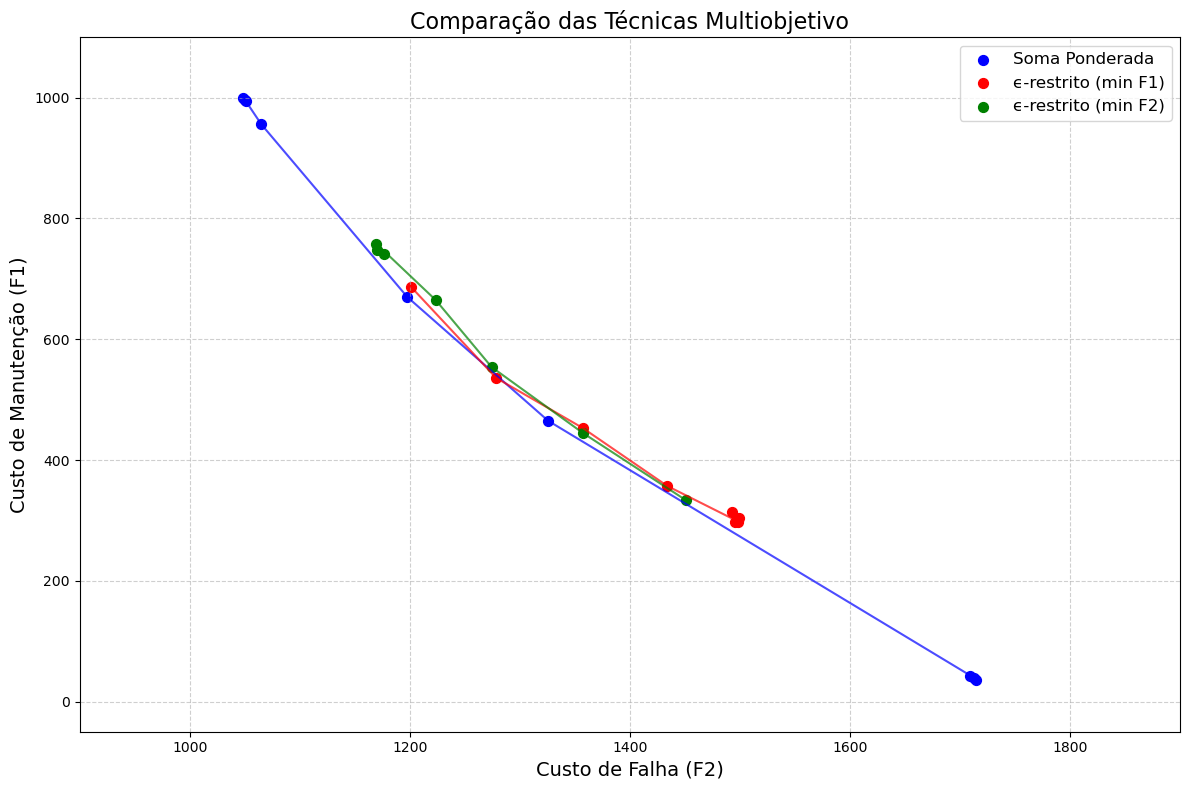

In [17]:
def plotar_todas_tecnicas_juntas(dados, num_pontos=10, max_iter=1000):
    tecnicas = ['soma_ponderada', 'epsilon_f1', 'epsilon_f2']
    cores = ['blue', 'red', 'green']
    labels = ['Soma Ponderada', 'ϵ-restrito (min F1)', 'ϵ-restrito (min F2)']

    plt.figure(figsize=(12, 8))

    for tecnica, cor, label in zip(tecnicas, cores, labels):
        print(f"Executando técnica: {label}")
        if tecnica == 'soma_ponderada':
            f1, f2, _ = gerar_fronteira_pareto(dados, num_pontos=num_pontos, max_iteracoes=max_iter, num_repeticoes=1)
        elif tecnica == 'epsilon_f1':
            f1, f2, _ = gerar_fronteira_epsilon(dados, num_pontos=num_pontos, max_iteracoes=max_iter, objetivo_principal='f1')
        elif tecnica == 'epsilon_f2':
            f1, f2, _ = gerar_fronteira_epsilon(dados, num_pontos=num_pontos, max_iteracoes=max_iter, objetivo_principal='f2')
        else:
            raise ValueError("Técnica desconhecida")

        plt.scatter(f2, f1, c=cor, label=label, s=50)
        plt.plot(f2, f1, c=cor, alpha=0.7)

    plt.title("Comparação das Técnicas Multiobjetivo", fontsize=16)
    plt.xlabel("Custo de Falha (F2)", fontsize=14)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.xlim(900, 1900)
    plt.ylim(-50, 1100)
    plt.tight_layout()
    plt.show()

# Execução:
if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    plotar_todas_tecnicas_juntas(dados, num_pontos=10, max_iter=100)
